In [3]:
import gc

import numpy as np
import tensorflow as tf
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from ultralytics import YOLO

from data.preprocess.tf import EmbeddingPreprocessor
from data.preprocess.torch import detector_preprocessing
from data.dataset.torch import DecklistDataset
from loss.torch.detection_loss import v8DetectionLoss
from utils.image_utils import make_square_shape
from utils import common, logger
from models.tf import EmbeddingModel
from models.torch import Detector

2025-06-25 23:04:30.128971: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-25 23:04:30.129131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-25 23:04:30.178513: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-25 23:04:30.284901: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-25 23:04:31.887210: W tensorflow/compiler/tf2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/d568/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [85]:
class TorchWarmUp(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, base_lr, warmup_epochs, total_epochs, steps_per_epoch, last_epoch=-1, decay_type="cosine"):
        self.optimizer = optimizer
        self.base_lr = base_lr
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.steps_per_epoch = steps_per_epoch
        self.decay_type = decay_type
        super(TorchWarmUp, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.last_epoch < self.warmup_steps:
            pass

In [86]:
def run_one_epoch(
    epoch,
    dataloader,
    student_model,
    teacher_model,
    loss_fn,
    is_train,
    optimizer,
):
    teacher_preprocess = EmbeddingPreprocessor()
    device = next(student_model.parameters()).device
    dtype = next(student_model.parameters()).dtype
    total_loss = torch.zeros(4)

    for batch in dataloader:
        # ground-truth preprocess
        images = batch["image"]
        batch_size = images.shape[0]
        batch["bboxes"] = torch.from_numpy(batch["xywh"])
        batch["batch_idx"] = torch.from_numpy(batch["batch_idx"])
        batch["cls"] = torch.zeros(size=batch["batch_idx"].shape, dtype=dtype)

        # make ground-truth embedding
        gt_embeds = []
        for i, img in enumerate(images):
            mask = batch["batch_idx"] == i
            teacher_inputs = []
            img_width, img_height, _ = img.shape # deck recipe image

            # get indivisual card position
            xyxy_list = batch["xyxy"][mask.numpy()]
            xyxy_list[:, [0, 2]] *= img_width
            xyxy_list[:, [1, 3]] *= img_height
            xyxy_list = np.round(xyxy_list).astype(np.int32)

            # crop card image
            for xyxy in xyxy_list:
                x1, y1, x2, y2 = xyxy
                crop = img[y1:y2, x1:x2, :]
                crop = teacher_preprocess.resize(crop)
                teacher_inputs.append(crop)
            teacher_inputs = tf.stack(teacher_inputs)
            teacher_embeds = teacher_model(teacher_inputs).numpy()
            teacher_embeds = torch.from_numpy(teacher_embeds)
            gt_embeds.append(teacher_embeds)
        batch["embedding"] = torch.concatenate(gt_embeds, dim=0)

        # student preprocess
        student_inputs = detector_preprocessing(images).to(device)

        # inference
        student_model.train()
        if is_train:
            preds = student_model(student_inputs)
        else:
            with torch.no_grad():
                preds = student_model(student_inputs)

        # loss
        loss, loss_item, fg_mask = loss_fn(preds, batch, embed_topk=1)
        total_loss += loss_item.detach().cpu() * batch_size

        # back propagation
        if is_train:
            optimizer.zero_grad()
            loss.backward()
            # norm_loss = grad_norm(loss_item[[0, 1, 3]])
            # print(grad_norm.weights)
            optimizer.step()

    return total_loss / len(dataloader.dataset)

In [88]:
# variables
use_logger = True
batch_size = 8
epochs = 100
train_embedding_only = False
log = logger.TrainLogger() if use_logger else None

# prepare datasets
train_dataset = DecklistDataset.load_from_csv("datasets/train.csv", (1, 2, 4))
train_dataset.zoom_scale = (0.5, 1.0)
train_dataset.pixelate_scale = (0.1, 1.0)
train_loader = DataLoader(
    train_dataset, batch_size, shuffle=True, collate_fn=train_dataset.collate_fn
)

student_model = Detector()
model_dict = student_model.state_dict()

# from checkpoint
pre_model_dict = torch.load("last.pt")
student_model.load_state_dict(pre_model_dict)

# for name, param in student_model.named_parameters():
#     if train_embedding_only:
#         if "embedding_layers" in name:
#             param.requires_grad_(True)
#         else:
#             param.requires_grad_(False)
#     else:
#         param.requires_grad_(False if "dfl" in name else True)

# for key in pre_model_dict.keys():
#     if "embedding" in key:
#         continue
#     model_dict[key] = pre_model_dict[key].clone().detach()
# student_model.load_state_dict(model_dict)
student_model = student_model.cuda()

# prevent TF model occupies all memories
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        raise e

# prepare teacher model
teacher_model = EmbeddingModel()
teacher_model.load("embedding/weights/best.h5")

# loss
device = next(student_model.parameters()).device
det_loss = v8DetectionLoss(head=student_model.layer22, device=device, box_gain=7.5, cls_gain=0.5, dfl_gain=1.5, embed_gain=1)
optimizer = AdamW(student_model.parameters(), lr=1e-4, weight_decay=0.01)

In [10]:
# training
best_loss = torch.inf
for epoch in range(epochs):
    train_dataset.shuffle()
    train_loss = run_one_epoch(
        epoch,
        train_loader,
        student_model,
        teacher_model,
        det_loss,
        True,
        optimizer,
    )

    if use_logger:
        log.info(f"epoch: {epoch}")
        log.info("train loss")
        log.info(
            f"det_loss: {train_loss[0]} cls_loss: {train_loss[1]} dfl_loss: {train_loss[2]} embed_loss: {train_loss[3]}"
        )

    gc.collect()
    torch.cuda.empty_cache()

    loss = train_loss.sum().detach().cpu().item()
    if loss < best_loss:
        torch.save(student_model.state_dict(), f"best.pt")
        best_loss = loss
    torch.save(student_model.state_dict(), f"last.pt")

KeyboardInterrupt: 

### Test Code

In [1]:
import cv2
import matplotlib.pyplot as plt
from db import ChromaDBConnection

chroma_db = ChromaDBConnection()

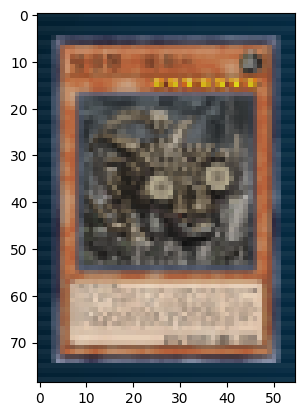

In [4]:
origin_img = cv2.imread("test3.png")[:,:,::-1]

plt.imshow(origin_img)
student_inputs, _, _ = make_square_shape(origin_img, 640)
student_inputs = detector_preprocessing(student_inputs.copy())
student_inputs = student_inputs[None, :]

In [5]:
student_model = Detector()
pre_model_dict = torch.load("best.pt")
student_model.load_state_dict(pre_model_dict)

student_model = student_model.cuda()
student_model.eval()

Detector(
  (layer0): Conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): SiLU()
  )
  (layer1): Conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): SiLU()
  )
  (layer2): C2f(
    (cv1): Conv(
      (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (cv2): Conv(
      (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (m): ModuleList(
      (0): Bottleneck(
        (cv1): Conv(
          (conv): Conv2d(16, 16, kernel_size=(3

In [6]:
with torch.no_grad():
    pred_det, pred_embed = student_model(student_inputs.cuda())
input_shape = student_inputs.shape[2:4]
det_results = student_model.postprocess(pred_det, pred_embed, input_shape, origin_img[None, :])

In [7]:
for i, det in enumerate(det_results):
    card_names = []
    card_ids = []
    for embed in det.embeds:
        res = chroma_db.search_by_embed(embed.tolist(), 5)[0]
        names = list(map(lambda x: x["name"], res))
        ids = list(map(lambda x: x["id"], res))
        card_names.append(names)
        card_ids.append(ids)
    det.names = card_names
    det.ids = card_ids
    det.save(f"res_{i}.png")

In [8]:
det.names

[['Redox, Dragon Ruler of Boulders',
  'Totem Five',
  'Blaster, Dragon Ruler of Infernos',
  'Black Fang Magician',
  'Extra-Foolish Burial']]

In [17]:
det_results[0].save("test3_result.png")

In [25]:
train_dataset.shuffle()

In [26]:
teacher_preprocess = EmbeddingPreprocessor()
device = next(student_model.parameters()).device
dtype = next(student_model.parameters()).dtype
total_loss = torch.zeros(4)
sample_count = 0

batch = next(iter(train_loader))

# ground-truth preprocess
images = batch["image"]
batch_size = images.shape[0]
batch["bboxes"] = torch.from_numpy(batch["xywh"])
batch["batch_idx"] = torch.from_numpy(batch["batch_idx"])
batch["cls"] = torch.zeros(size=batch["batch_idx"].shape, dtype=dtype)

# make ground-truth embedding
gt_embeds = []
for i, img in enumerate(images):
    mask = batch["batch_idx"] == i
    teacher_inputs = []
    img_width, img_height, _ = img.shape # deck recipe image

    # get indivisual card position
    xyxy_list = batch["xyxy"][mask.numpy()]
    xyxy_list[:, [0, 2]] *= img_width
    xyxy_list[:, [1, 3]] *= img_height
    xyxy_list = np.round(xyxy_list).astype(np.int32)

    # crop card image
    for xyxy in xyxy_list:
        x1, y1, x2, y2 = xyxy
        crop = img[y1:y2, x1:x2, :]
        cv2.imwrite("test2.png", img[:,:,::-1])
        cv2.imwrite("test.png", crop[:,:,::-1])
        crop = teacher_preprocess.resize(crop)
        teacher_inputs.append(crop)
    teacher_inputs = tf.stack(teacher_inputs)
    teacher_embeds = teacher_model(teacher_inputs).numpy()
    teacher_embeds = torch.from_numpy(teacher_embeds)
    gt_embeds.append(teacher_embeds)
batch["embedding"] = torch.concatenate(gt_embeds, dim=0)

# student preprocess
student_inputs = detector_preprocessing(images).to(device)
preds = student_model(student_inputs)

In [105]:
teacher_model = EmbeddingModel()
teacher_model.load("embedding/weights/best.h5")

In [106]:
crop = teacher_preprocess.resize(cv2.imread("ancient.png")[:,:,::-1])
teacher_input = tf.expand_dims(crop, 0)
pred = teacher_model(teacher_input)

In [107]:
pred[0]

<tf.Tensor: shape=(256,), dtype=float32, numpy=
array([   0.067057,     0.22892,           0,           0,     0.22481,           0,           0,           0,           0,           0,           0,           0,     0.30284,    0.057212,           0,           0,    0.051515,           0,    0.093791,           0,           0,           0,           0,           0,
                 0,           0,           0,    0.043591,           0,    0.046526,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                 0,           0,           0,           0,           0,           0,           0,           0,     0.24923,   0.0041841,           0,    0.059571,           0,           0,           0,           0,     0.08499,           0,           0,           0,           0,    0.041787,           0,     0.00

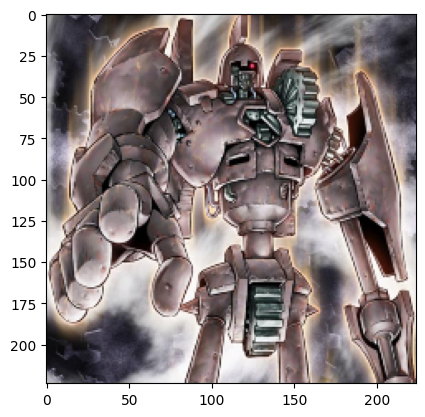

In [108]:
plt.imshow(teacher_input[0].numpy())

In [109]:
test = pred.numpy().tolist()[0]
test_res = chroma_db.search_by_embed(test, 20)[0]

In [110]:
for data in test_res:
    print(data["kor_name"], data["image_url_small"])

패재생 https://images.ygoprodeck.com/images/cards_small/73271204.jpg
완전 방음벽 https://images.ygoprodeck.com/images/cards_small/42314669.jpg
방해꾼 매직 https://images.ygoprodeck.com/images/cards_small/24643836.jpg
이차원 에스퍼 스타 로빈 https://images.ygoprodeck.com/images/cards_small/80208158.jpg
취사소생 https://images.ygoprodeck.com/images/cards_small/50213848.jpg
태양의 제단 https://images.ygoprodeck.com/images/cards_small/91468551.jpg
버제스토마 올레노이데스 https://images.ygoprodeck.com/images/cards_small/35035481.jpg
모노케로스 https://images.ygoprodeck.com/images/cards_small/58807980.jpg
데코이로이드 https://images.ygoprodeck.com/images/cards_small/25034083.jpg
체인소우 인섹트 https://images.ygoprodeck.com/images/cards_small/77252217.jpg
베리어 레조네이터 https://images.ygoprodeck.com/images/cards_small/89127526.jpg
신의 거성－발할라 https://images.ygoprodeck.com/images/cards_small/1353770.jpg
전환기괴 컨센트롤 https://images.ygoprodeck.com/images/cards_small/78447174.jpg
The Legend of Tickets https://images.ygoprodeck.com/images/cards_small/54120521.jpg
진룡

In [29]:
batch["embedding"].shape

torch.Size([11, 256])

In [ ]:
from db.db import ChromaDB

chroma_db = ChromaDB()